## 
compute climatology weekly


##  Calculating anomaly and trend with sea ice thickness time series

In this exercise, we will use the sea ice thickness data in the Arctic region, available through the PolarWatch data server, to study changes in monthly average sea ice thickness values.  We will compare the current state of sea ice thickness to the historical mean and also evaluate the long-term trend from the data.

### The exercise demonstrates the following techniques:
- Loading twice daily sea ice thickness data of the year 2023 from ERDDAP using `xarray` and compute monthly average
- Loading multi-year monthly average sea ice thickness data from netCDF file
- Calculating the trend of monthly sea ice thickness means for the climatological reference period of 2006 to 2020 (15 years)
- Calculating historical average of the reference period (2006-2020)
- Calculating anomalies (departures from the historical mean)
- Visualizing the data 

### Datasets used:
- 25-km sea ice thickness for the Arctic from the NOAA Climate Data Record (CDR) of the Extended Polar Pathfinder cryosphere dataset from NCEI. Twice daily data are available from 1982 to present.
 https://polarwatch.noaa.gov/catalog/ice-thick-sq-nh-appx/preview/?dataset=daily&var=cdr_sea_ice_thickness&time_min=2024-08-28T14:00:00Z&time_max=2024-08-28T14:00:00Z&proj=epsg3413&colorBar=KT_amp|||0|3|

- 25-km sea ice thickess monthly average data from 2005 to 2020.

_In this exercise, monthly means were computed from the 25-km sea ice thickness dataset under the assumption of equal sampling and no missing data. Therefore, no weights were applied in this instance. In cases where data gaps or uneven sampling occur, applying appropriate weights is recommended for more accurate climatological calculations._


### Import Python packages

In [1]:
# Load packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymannkendall as mk

### Load data from PolarWatch ERDDAP data server

We will begin by obtaining the current sea ice thickness data from the PolarWatch ERDDAP data server. The data request is made using a URL that includes the ERDDAP address and a unique dataset ID.


In [2]:
# Define the URL for the PolarWatch sea ice thickness dataset on the ERDDAP server
erddap_url = "https://polarwatch.noaa.gov/erddap/griddap/ncei_polarAPPX20_nhem"  

# Use xarray function to load the dtaset from the EREDDAP URL
ds1 = xr.open_dataset(erddap_url)   

# Display the dataset metadata 
ds1 

<xarray.Dataset> Size: 309GB
Dimensions:                                    (time: 29685, rows: 361,
                                                columns: 361)
Coordinates:
  * time                                       (time) datetime64[ns] 237kB 19...
  * rows                                       (rows) float32 1kB -4.5e+06 .....
  * columns                                    (columns) float32 1kB -4.525e+...
Data variables: (12/20)
    cdr_sea_ice_thickness                      (time, rows, columns) float32 15GB ...
    cdr_surface_temperature                    (time, rows, columns) float32 15GB ...
    cdr_surface_albedo                         (time, rows, columns) float32 15GB ...
    cdr_surface_downwelling_shortwave_flux     (time, rows, columns) float32 15GB ...
    cdr_surface_downwelling_longwave_flux      (time, rows, columns) float32 15GB ...
    cdr_surface_upwelling_shortwave_flux       (time, rows, columns) float32 15GB ...
    ...                                         ...
    cloud_optical_depth                        (time, rows, columns) float32 15GB ...
    cloud_top_pressure                         (time, rows, columns) float32 15GB ...
    cloud_top_temperature                      (time, rows, columns) float32 15GB ...
    cloud_type                                 (time, rows, columns) float32 15GB ...
    surface_shortwave_cloud_radiative_forcing  (time, rows, columns) float32 15GB ...
    surface_longwave_cloud_radiative_forcing   (time, rows, columns) float32 15GB ...
Attributes: (12/44)
    _NCProperties:              version=2,netcdf=4.8.1,hdf5=1.10.6
    acknowledgement:            Please acknowledge NCEI, CoastWatch West Coas...
    cdm_data_type:              Grid
    cdr_program:                NOAA Climate Data Record Program for satellites
    cdr_variable:               cdr_surface_temperature, cdr_surface_albedo, ...
    comment:                    In order to be compliant with the EASE Grid s...
    ...                         ...
    spatial_resolution:         25 km
    standard_name_vocabulary:   CF Standard Name Table (v26, 08 November 2013)
    summary:                    summary
    time_coverage_end:          2024-08-28T14:00:00Z
    time_coverage_start:        1982-01-01T04:00:00Z
    title:                      Sea Ice Thickness and Multi-variable Extended...

### Load 2023 data and compute monthly average

```# Load data from year 2021
ds1.sel(time=slice('2023-01-01', '2023-12-31'))

# Compute montly average
ds_23_monthly = ds1.groupby("time.month").mean()

# Close dataset to free up memory
ds1.close()
```

In [11]:
ds_21 = xr.open_dataset('thickness21.nc')
ds_21_clm = ds_21.groupby('time.month').mean()

### Visualize the monthly mean on the map

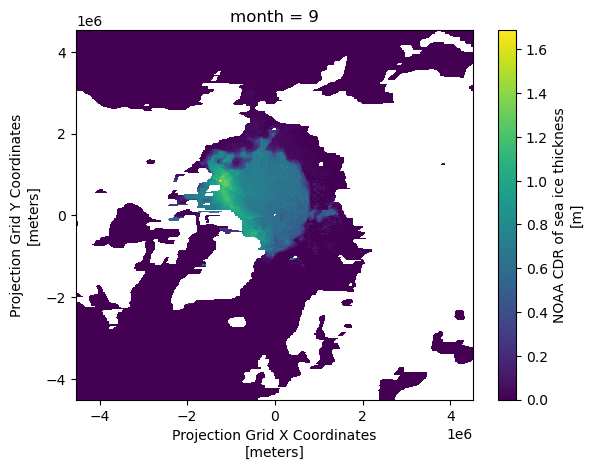

In [15]:
# Visualize the January sea ice thickness mean (first time step: index[0])
ds_21_clm['cdr_sea_ice_thickness'][0].plot()

### Load monthly average from 2005 to 2020

To do climate analysis such as computing climatology and trend analysis, we will use sea ice thickness monthly average from 2005 to 2020.  The monthly averages are already computed and are available in netcdf file.

In [5]:
# Load monthly average data for 2006-2020 
ds2 = xr.open_dataset('monthlyseaicethickness_2006_2020.nc') 

### Compute the 20 year historical mean

Using `ds2` dataset, we will compute 15 year historical monthly means.



In [6]:
# Compute monthly mean from annualized data
clim_mean = ds2.mean(dim='year')
clim_mean

<xarray.Dataset> Size: 6MB
Dimensions:                (month: 12, rows: 361, columns: 361)
Coordinates:
  * rows                   (rows) float32 1kB -4.5e+06 -4.475e+06 ... 4.525e+06
  * columns                (columns) float32 1kB -4.525e+06 -4.5e+06 ... 4.5e+06
  * month                  (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    cdr_sea_ice_thickness  (month, rows, columns) float32 6MB 0.0 0.0 ... 0.0

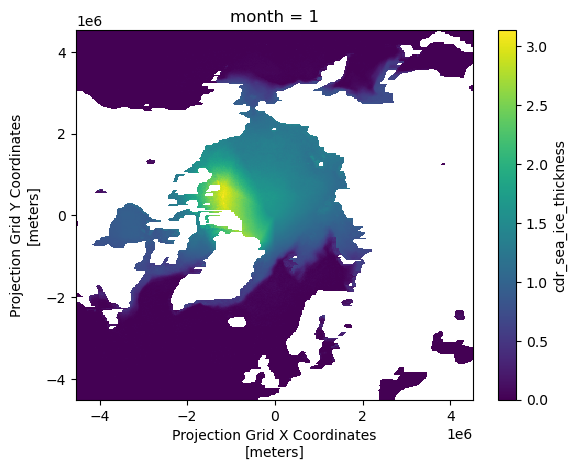

In [7]:
clim_mean['cdr_sea_ice_thickness'][0].plot()

### Compute anomaly  

To understand the recent change in the sea ice thickness, we can compare the current state (year 2021) to the historical mean.  Anomaly is a commonly used metric representing the difference (or departure).

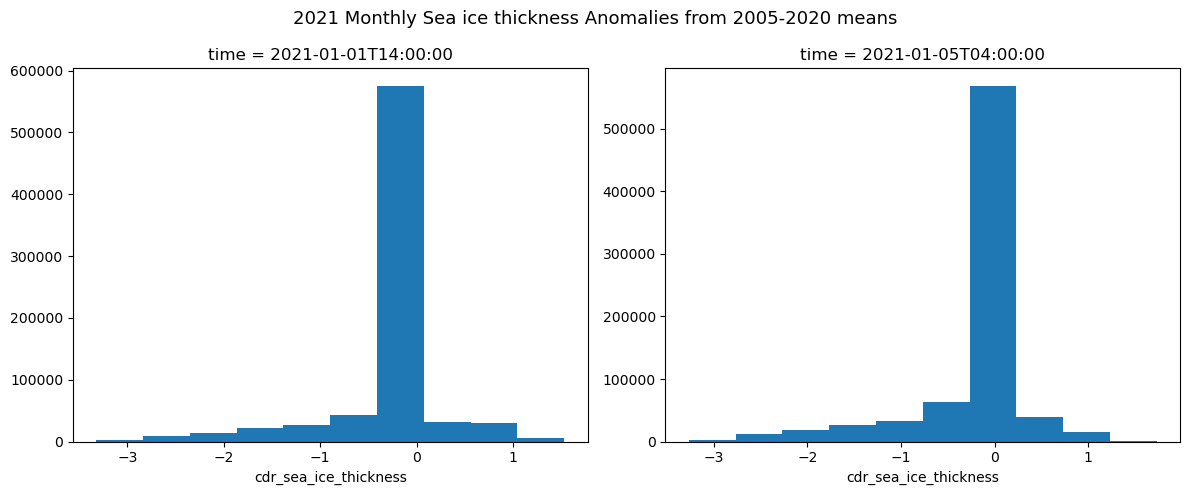

In [9]:
# Compute anomaly of 2021 from the mean data
anom_mean = ds_21_clm['cdr_sea_ice_thickness'] - clim_mean['cdr_sea_ice_thickness']

# Plot Feb and Sep anomaly
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
anom_mean[1].plot(ax=axs[0])
anom_mean[8].plot(ax=axs[1])

# Set the title
fig.suptitle('2021 Monthly Sea ice thickness Anomalies from 2005-2020 means', fontsize=13)

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()


### Compute trends

https://www.geeksforgeeks.org/how-to-perform-a-mann-kendall-trend-test-in-python/

A trend in climatology refers to a long-term change over an extended period of time.  There are few ways to estimate the trend in the time series data.   For this exercise, we will apply `mk_slope()` to use Mann-Kendall regression to compute the slope and conduct significance testing.  Mann-Kendall is a non-parametric method that relaxes the underlying assumptions about normality of data.

_The code takes longer time to process. It tooks 3 minutes on my computer_

In [18]:


# Define a function to apply the Mann-Kendall test and return the slope
def mk_slope(data):

# remove NaN data points
    clean_data = data[~np.isnan(data)]
# if data points not enough, return Nan 
    if len(clean_data) < 2:
            return np.nan     
    # Apply MK analysis
    result = mk.original_test(data)
    # Return only slope
    return result.slope

# Using xarray.apply_ufunc(), we will apply mk_slope across the 'time' (monthly)  dimension for each grid
# Apply the function across the 'time' dimension for each pixel
slopes = xr.apply_ufunc(
    mk_slope,                # The function to apply
    ds2,                    # The data 
    input_core_dims=[['year']],  # The dimension over which to apply the function
    vectorize=True,          # Vectorize to apply across all grid
    dask='parallelized',     # Enable parallel processing if using Dask
    output_dtypes=[float]    # The output type (float for slope)
)



## Visualize the trend (slope) for each grid

The slopes are computed for each month and grid over the 15 years (2005-2020). We will select the slopes for September and visualize.

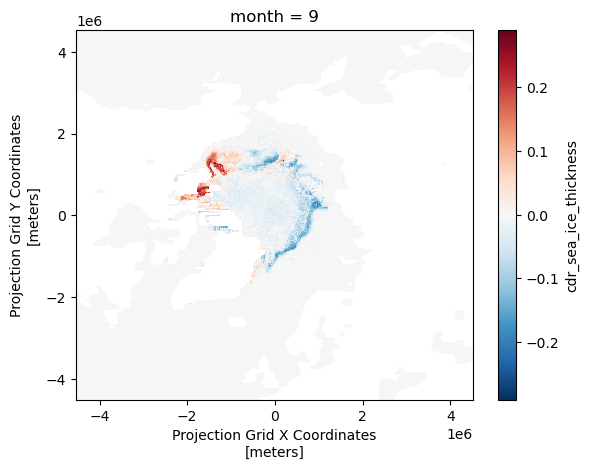

In [23]:
slopes['cdr_sea_ice_thickness'].sel(month=9).plot()